In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import pandas as pd
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import hdbscan
import numpy as np
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve



In [3]:
# Data Preprocessing

In [4]:

# Filter for individual customers
ddf = dd.read_parquet('transactions.parquet')
ddf_individual = ddf[ddf['CUSTOMER_TYPE'] == 'Cá nhân']

# Compute the filtered dataframe to bring it into memory as a Pandas DataFrame
df_individual = ddf_individual.compute()

# Select specific columns
df_individual = df_individual[['CUST_CUSTNO', 'total_deposits', 'total_withdrawals']]

# Display the filtered dataframe
df_individual



,CUST_CUSTNO,total_deposits,total_withdrawals
0,0000007773223f2870cd370943080c676696b5281dbe75...,120.0,-4100.0
1,00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...,5400.0,-9600.0
2,0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...,50.0,0.0
3,00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...,0.0,-5000.0
4,00013c38ac340d54e458cc923fbfed7171c5586877fd60...,0.0,-67453.4
...,...,...,...
195139,fffeae132cbb21f07d46942cde6fe6af1895e37de37fec...,0.0,-27.0
195140,fffedbd9aabeeb0fbd3267484e5afa3ddbe03834319602...,0.0,-389.0
195141,ffff174fed6d742e6eb7b30843430e86fd6281ef8d96b4...,367.0,-671.75
195142,ffff9730c2642fc5484a35fef7543417deced83c277fab...,1100.0,-500.0


In [5]:
# Log Transform the Data
df_individual['log_total_deposits'] = np.log1p(df_individual['total_deposits'])
df_individual['log_total_withdrawals'] = np.log1p(df_individual['total_withdrawals'].abs())


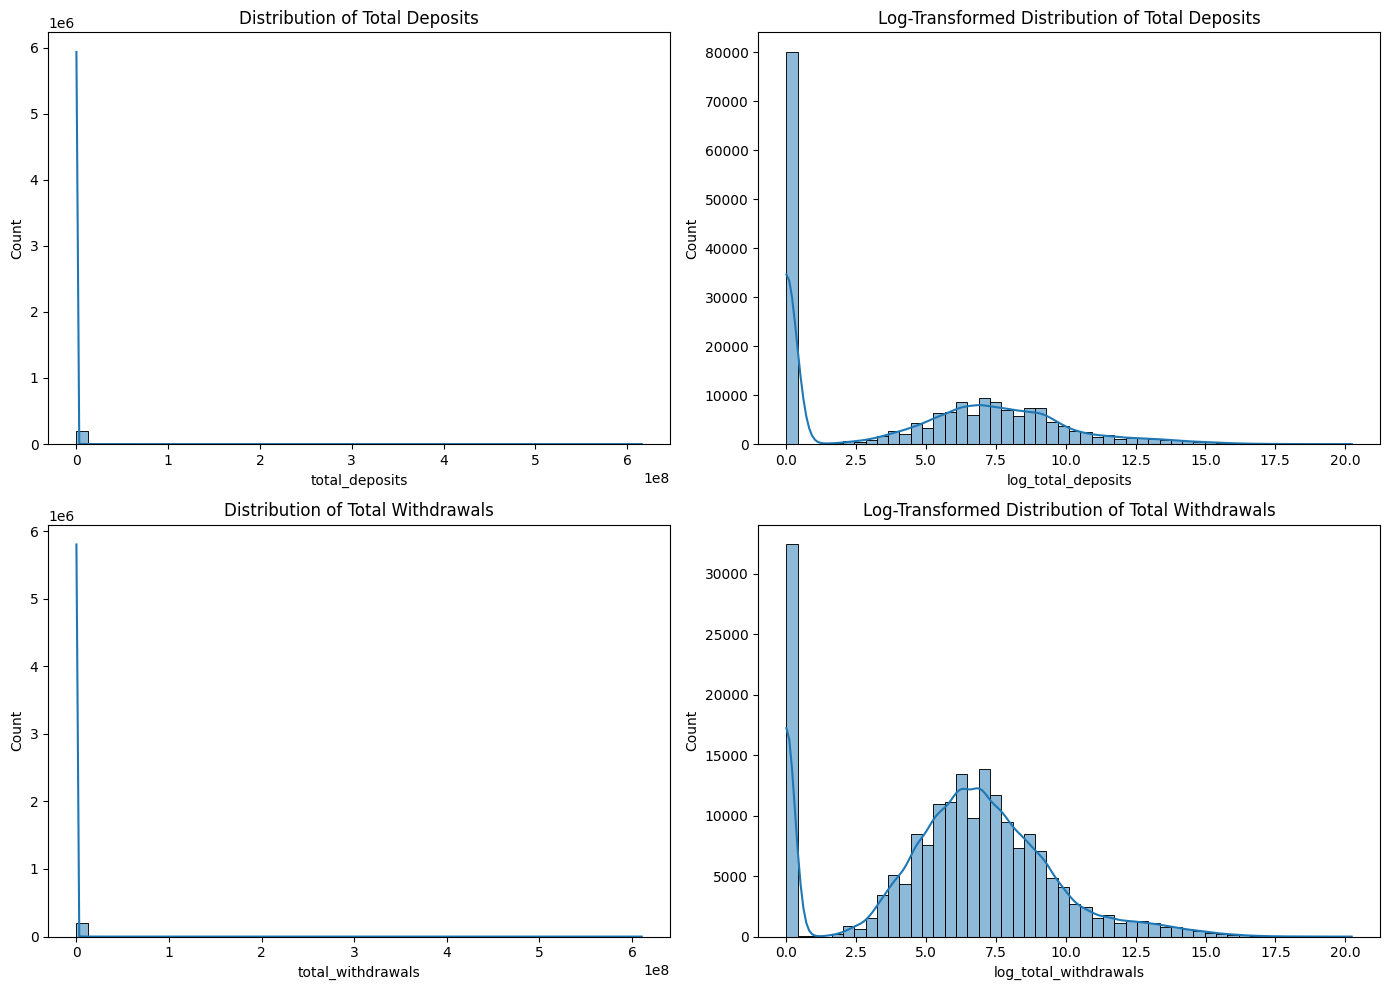

In [25]:
# Plot the distributions before and after log transformation
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(df_individual['total_deposits'], bins=50, kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Total Deposits')

sns.histplot(df_individual['log_total_deposits'], bins=50, kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Log-Transformed Distribution of Total Deposits')

sns.histplot(df_individual['total_withdrawals'].abs(), bins=50, kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Total Withdrawals')

sns.histplot(df_individual['log_total_withdrawals'], bins=50, kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Log-Transformed Distribution of Total Withdrawals')

plt.tight_layout()
plt.show()

In [6]:
# Prepare the data for clustering
features = df_individual[['log_total_deposits', 'log_total_withdrawals']].values


In [7]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

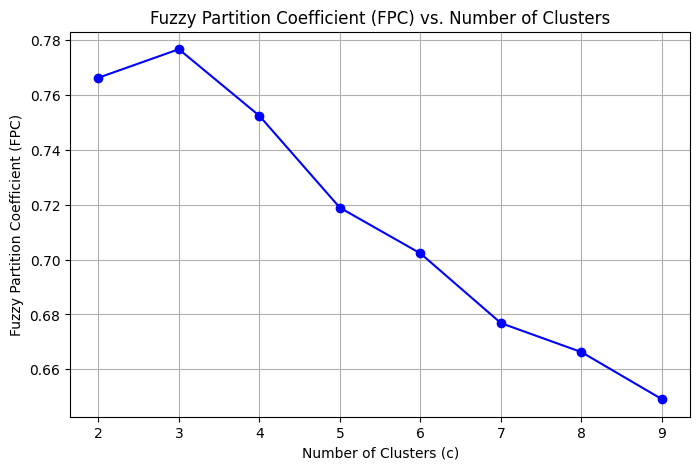

In [11]:
# Define the range of clusters to evaluate
n_clusters_range = range(2, 10)
fpc_values = []

for n_clusters in n_clusters_range:
    # Apply Fuzzy C-Means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        features_scaled.T, 
        c=n_clusters, 
        m=2, 
        error=0.005, 
        maxiter=1000, 
        init=None
    )

    # Store the FPC value for this number of clusters
    fpc_values.append(fpc)

# Plot FPC values to visualize the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, fpc_values, marker='o', linestyle='-', color='b')
plt.title('Fuzzy Partition Coefficient (FPC) vs. Number of Clusters')
plt.xlabel('Number of Clusters (c)')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.xticks(n_clusters_range)
plt.grid(True)
plt.show()


In [8]:
# Set the number of clusters
n_clusters = 3

In [9]:
# Apply Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

In [10]:
# Assign clusters to each transaction based on the highest membership
cluster_labels = np.argmax(u, axis=0)

In [11]:
# Add the cluster labels to the DataFrame
df_individual['cluster'] = cluster_labels

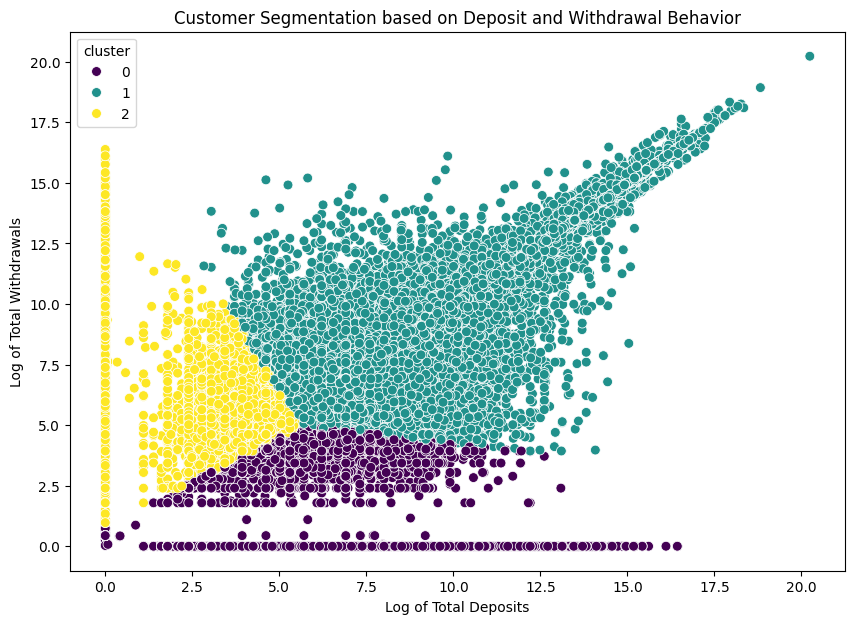

In [12]:
# Visualize the distribution of transactions in each cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(x='log_total_deposits', y='log_total_withdrawals', hue='cluster', data=df_individual, palette='viridis', s=50)
plt.title('Customer Segmentation based on Deposit and Withdrawal Behavior')
plt.xlabel('Log of Total Deposits')
plt.ylabel('Log of Total Withdrawals')
plt.show()


In [13]:
# Count the number of transactions in each cluster
df_individual['cluster'].value_counts()

cluster
2    88750
1    68591
0    36702
Name: count, dtype: int64

In [14]:
# Calculate suspicion scores based on distance from the cluster centroid
suspicion_scores = np.min(d, axis=0)
df_individual['suspicion_score'] = suspicion_scores

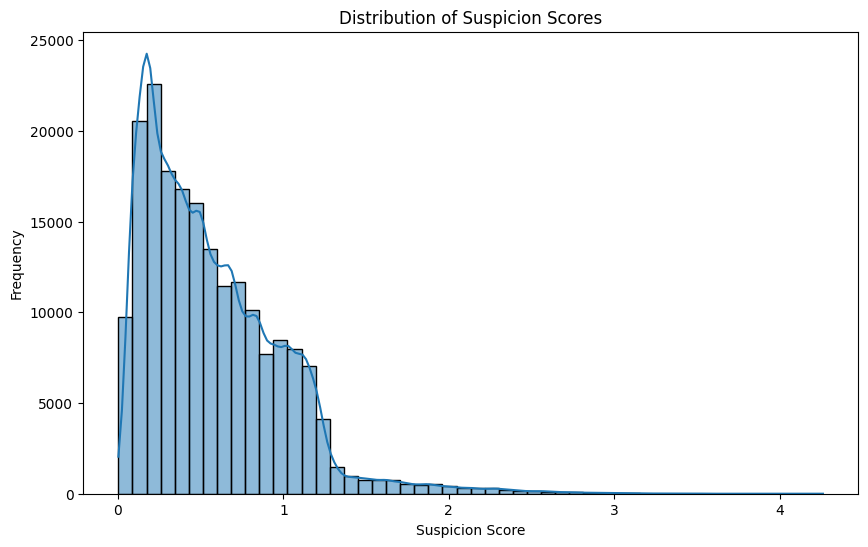

Mean: 0.5714
Standard Deviation: 0.4200
Skewness: 1.4094
Kurtosis: 3.3024


In [15]:
# Plot the distribution of suspicion scores
plt.figure(figsize=(10, 6))
sns.histplot(df_individual['suspicion_score'], bins=50, kde=True)
plt.title('Distribution of Suspicion Scores')
plt.xlabel('Suspicion Score')
plt.ylabel('Frequency')
plt.show()
mean_score = df_individual['suspicion_score'].mean()
std_score = df_individual['suspicion_score'].std()
skewness_score = df_individual['suspicion_score'].skew()
kurtosis_score = df_individual['suspicion_score'].kurtosis()

print(f"Mean: {mean_score:.4f}")
print(f"Standard Deviation: {std_score:.4f}")
print(f"Skewness: {skewness_score:.4f}")
print(f"Kurtosis: {kurtosis_score:.4f}")


Text(0, 0.5, 'Density')

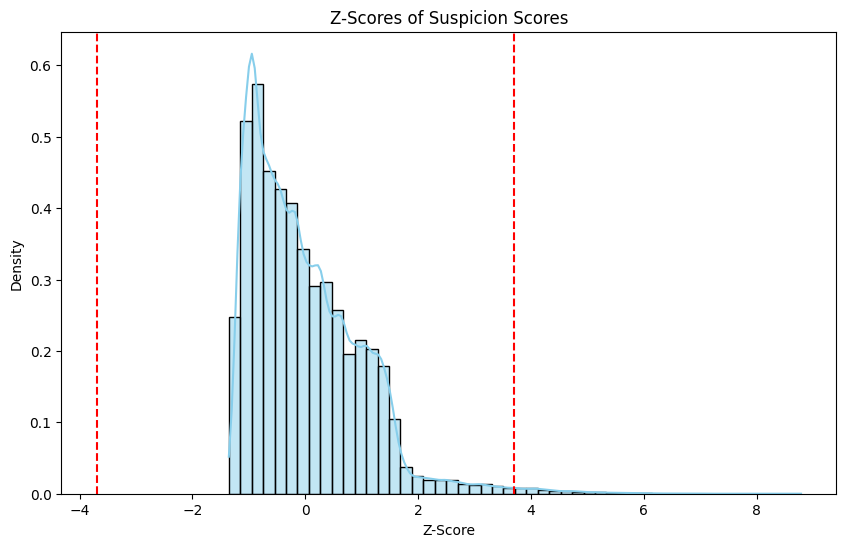

In [40]:
# Calculate the Z-scores for each suspicion score
df_individual['z_score'] = (df_individual['suspicion_score'] - mean_score) / std_score

# Set the Z-score threshold for anomaly detection
z_score_threshold = 3.7 # You can adjust this to 3 or other values based on your preference

# Flag the anomalies based on the Z-score threshold
df_individual['is_anomaly'] = df_individual['z_score'].apply(lambda x: abs(x) > z_score_threshold)

# Plotting Z-scores for anomaly detection
plt.figure(figsize=(10, 6))
sns.histplot(df_individual['z_score'], bins=50, kde=True, color='skyblue', stat="density")
plt.axvline(z_score_threshold, color='red', linestyle='--', label=f'Z-Score Threshold: {z_score_threshold}')
plt.axvline(-z_score_threshold, color='red', linestyle='--')
plt.title('Z-Scores of Suspicion Scores')
plt.xlabel('Z-Score')
plt.ylabel('Density')

In [41]:
df_individual

,CUST_CUSTNO,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,suspicion_score,z_score,is_anomaly,rule_15_label
0,0000007773223f2870cd370943080c676696b5281dbe75...,120.0,-4100.0,4.795791,8.318986,1,0.933002,0.860802,False,0
1,00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...,5400.0,-9600.0,8.594339,9.169623,1,0.115071,-1.086497,False,0
2,0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...,50.0,0.0,3.931826,0.0,0,0.672896,0.241552,False,0
3,00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...,0.0,-5000.0,0.0,8.517393,2,0.640357,0.164083,False,0
4,00013c38ac340d54e458cc923fbfed7171c5586877fd60...,0.0,-67453.4,0.0,11.119207,2,1.388098,1.944276,False,0
...,...,...,...,...,...,...,...,...,...,...
195139,fffeae132cbb21f07d46942cde6fe6af1895e37de37fec...,0.0,-27.0,0.0,3.332205,2,0.861415,0.690371,False,0
195140,fffedbd9aabeeb0fbd3267484e5afa3ddbe03834319602...,0.0,-389.0,0.0,5.966147,2,0.122797,-1.068105,False,0
195141,ffff174fed6d742e6eb7b30843430e86fd6281ef8d96b4...,367.0,-671.75,5.908083,6.511374,1,0.932037,0.858505,False,0
195142,ffff9730c2642fc5484a35fef7543417deced83c277fab...,1100.0,-500.0,7.003974,6.216606,1,0.844345,0.649730,False,0


In [42]:
# Apply rule 15 to df_individual
rule_15_anomalies = df_individual[
    (
        (df_individual['total_deposits'].abs() >= 6000000) | (df_individual['total_withdrawals'].abs() >= 6000000)
    ) & 
    (df_individual['total_withdrawals'].abs() >= 0.95 * df_individual['total_deposits'])
]

rule_15_anomalies


,CUST_CUSTNO,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,suspicion_score,z_score,is_anomaly,rule_15_label
51,001649736bcafeaf5a9c1c5c5262a7d4451df41b9c222c...,8593437.78,-8508170.64,15.96651,15.956538,1,2.674198,5.006175,True,1
1204,0191cf57de3d54f5112226efd558e976c801681f4736b5...,14023666.97,-14022647.25,16.456257,16.456184,1,2.858405,5.444728,True,1
1287,01a933d4323788d065e400b4b90eaa1e702f3fc5709574...,7889532.14,-7820273.19,15.881048,15.87223,1,2.642696,4.931176,True,1
1543,0202c9077426bdc83d1a46df8e062738c27632e1c35238...,13707567.12,-13603783.61,16.433459,16.425859,1,2.848255,5.420563,True,1
1621,0220168858cafaa2b38ef9fdc33c7ddabf9bf5716ab926...,21965418.69,-21960000.0,16.90498,16.904733,1,3.025122,5.841641,True,1
...,...,...,...,...,...,...,...,...,...,...
193300,fd9d7f98599e30315fbf5284f7a35ca8e52f9b10fcb43e...,8204558.9,-24204558.94,15.920201,17.002052,1,2.907079,5.560608,True,1
193500,fddd7fc2e0f3c95224ea676ca6b090b64183f6f52a9804...,10594759.43,-10570500.01,16.17587,16.173578,1,2.753712,5.195480,True,1
193953,fe6b387f78da8da0167ba9cf4ffe2bacbf78f4061f74dc...,4254749.68,-6409499.2,15.263547,15.673292,1,2.507604,4.609554,True,1
194243,fed6e67003861462eb13e4fdd8e4923a21e2bc84f0be07...,78002809.43,-77317404.71,18.172255,18.16343,1,3.494157,6.958302,True,1


In [43]:
len(rule_15_anomalies)

481

In [49]:
# Check the unique clusters assigned
print(rule_15_anomalies['cluster'].unique())

# Count the number of transactions per cluster
transactions_per_cluster = rule_15_anomalies.groupby('cluster').size()
print(transactions_per_cluster)


[1 2]
cluster
1    475
2      6
dtype: int64


In [54]:
# Filter anomalies where cluster is 2
cluster_2_anomalies = rule_15_anomalies[rule_15_anomalies['cluster'] == 2]

# Display the anomalies
print(cluster_2_anomalies)


                                              CUST_CUSTNO  total_deposits  \
17492   16f128bc45acbedfabdbbe70a3a950e9125f080af86121...             0.0   
56060   4992788709791b98fd829127df2da09f281f3e32a95031...             0.0   
95737   7e0a3d7ffc9d92f11c10392f27ff49ccd8238f24c55b33...             0.0   
126357  a64a28425365698dbd77dac92a94f7cab788f098ab0ad5...             0.0   
159204  d117debe9bc8ffa890720a1be77c6fb74d9a919520d4b3...             0.0   
192255  fc3342b45b0124ed4f170ae08ea90ebe085e43d786665a...             0.0   

        total_withdrawals  log_total_deposits  log_total_withdrawals  cluster  \
17492         -9500499.99                 0.0              16.066855        2   
56060         -7297803.47                 0.0              15.803084        2   
95737         -13000000.0                 0.0               16.38046        2   
126357         -8808000.0                 0.0              15.991171        2   
159204         -7003560.0                 0.0          

In [45]:
# Adding the Rule 15 label for precision, recall, and FPR calculation
df_individual['rule_15_label'] = df_individual.index.isin(rule_15_anomalies.index).astype(int)  # 1 = Fraudulent, 0 = Normal

# Compute precision, recall, and confusion matrix
precision = precision_score(df_individual['rule_15_label'], df_individual['is_anomaly'])
recall = recall_score(df_individual['rule_15_label'], df_individual['is_anomaly'])

# Compute confusion matrix to extract FP and TN
tn, fp, fn, tp = confusion_matrix(df_individual['rule_15_label'], df_individual['is_anomaly']).ravel()

# Compute False Positive Rate (FPR)
fpr = fp / (fp + tn)

# Print the evaluation metrics
print(f"Precision: {precision:.4f}")
print(f"Recall (True Positive Rate): {recall:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")

Precision: 0.2967
Recall (True Positive Rate): 1.0000
False Positive Rate (FPR): 0.0059


In [46]:
rule15_cif = pd.read_excel('CIF_HASH 14122024.xlsx')
rule15_cif = rule15_cif[['CUST']]
rule15_cif = rule15_cif.rename(columns={'CUST': 'CUST_CUSTNO'})
rule15_cif

,CUST_CUSTNO
0,4a7ac6a7d71c8dd43d07ea99ed57b947d4625ffb1ee7ba...
1,5ff908d766a8431c0480eaaa66f0c7f4f981ea36bb09db...
2,b585979be38eb995869128769142e7299db20874f0d8be...
3,55eeb636a10285eb1f8f8f5a6c2a8f210b2c5cc673546e...
4,039444b700a770ced03250af136ba9c2578a7136ef800d...
5,704f2775efdf525bc5319d057fc066417f464811e2889d...
6,fd9d7f98599e30315fbf5284f7a35ca8e52f9b10fcb43e...
7,21bc03333bc9f8a30ab9e8a05fbe675320dab245e282d3...
8,c7d19d1ad02b35b3a8c43f8381705ceac0a2c31cde3740...


In [47]:
ddf_filteredx = rule_15_anomalies.merge(rule15_cif, on='CUST_CUSTNO', how='right')
ddf_filteredx

,CUST_CUSTNO,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,suspicion_score,z_score,is_anomaly,rule_15_label
0,4a7ac6a7d71c8dd43d07ea99ed57b947d4625ffb1ee7ba...,42728096.58,-65899418.85,17.570367,18.00364,1,3.370007,6.662731,True,1
1,5ff908d766a8431c0480eaaa66f0c7f4f981ea36bb09db...,19900681.84,-21928607.94,16.806265,16.903303,1,3.010180,5.806069,True,1
2,b585979be38eb995869128769142e7299db20874f0d8be...,7273818.15,-21352635.78,15.799792,16.876686,1,2.861261,5.451528,True,1
3,55eeb636a10285eb1f8f8f5a6c2a8f210b2c5cc673546e...,39516937.48,-58818914.14,17.49224,17.889974,1,3.332908,6.574407,True,1
4,039444b700a770ced03250af136ba9c2578a7136ef800d...,8373577.74,-23412154.89,15.940592,16.968766,1,2.902053,5.548643,True,1
5,704f2775efdf525bc5319d057fc066417f464811e2889d...,9248178.16,-27496356.23,16.039937,17.129564,1,2.953310,5.670674,True,1
6,fd9d7f98599e30315fbf5284f7a35ca8e52f9b10fcb43e...,8204558.9,-24204558.94,15.920201,17.002052,1,2.907079,5.560608,True,1
7,21bc03333bc9f8a30ab9e8a05fbe675320dab245e282d3...,7912330.19,-23524660.28,15.883933,16.97356,1,2.895455,5.532936,True,1
8,c7d19d1ad02b35b3a8c43f8381705ceac0a2c31cde3740...,15326286.31,-45567572.46,16.54508,17.634707,1,3.140674,6.116744,True,1


In [48]:
# Sort the dataframe to get the top anomalies based on the suspicion score
top_anomalies = df_individual[df_individual['is_anomaly']].sort_values(by='z_score', ascending=False)

# Display the top anomalies (You can adjust the number of top anomalies you want to see)
top_anomalies_display = top_anomalies.head(10)  # Show top 10 anomalies with highest suspicion score

# Display the top anomalies with the highest suspicion scores
print("High risky Anomalies with High Suspicion Scores:")
print(top_anomalies_display[['CUST_CUSTNO', 'total_deposits', 'total_withdrawals', 'suspicion_score', 'z_score']])



High risky Anomalies with High Suspicion Scores:
                                              CUST_CUSTNO  total_deposits  \
16543   15b42f45f82bb2f3fae9a93030d59b4884a9301a643cbb...    615862697.16   
3829    05049a1941f462bcc2aa404a5476a932f6c8b058131d06...    148966211.52   
71135   5d46592a5feb8b5692cf5e62b9ff25366e6e54791e6fc0...     85661527.28   
133460  afa467fbd78003935a6a5a8e084186edf762df85d96d44...     85329202.11   
41880   36e455f05d73dc925ffe402781f2eb6dab866d639eb694...     80542821.95   
134111  b0858a70e277da8752eec249b279213ccf91954a8d4558...     92430258.08   
56642   4a49b23b2bb180324ae5ef5feaf288e07b42c6f81bd011...     78498265.33   
164605  d8168292b695c7bb5ce032a20dcb86b83ebe4bc59bac65...     61684602.79   
194243  fed6e67003861462eb13e4fdd8e4923a21e2bc84f0be07...     78002809.43   
32942                    2b357a1460c30a41fe106594e9191007      75906446.3   

        total_withdrawals  suspicion_score   z_score  
16543       -610451234.37         4.262034  8.78